In [11]:
import pandas as pd
import json
metrics_rows = []

with open('/content/sample_data/llm_dataset_resource_exhaustion_metadata_1742916118.jsonl', 'r') as f:
    for line in f:
        record = json.loads(line)
        timestamp = pd.to_datetime(record["datetime"])
        for key, value in record.items():
            if key.startswith("sensor_") or key.startswith("gateway_") or key.startswith("dataserver_"):
                parts = key.split("_")
                metric_type = parts[0]  # e.g., sensor
                metric_name = "_".join(parts[1:-1])  # e.g., cpu_usage_percent
                sensor_id = parts[-1]  # e.g., temperature-sensor-01

                metrics_rows.append({
                    "datetime": timestamp,
                    "sensor": sensor_id,
                    "metric": f"{metric_type}_{metric_name}",
                    "value": float(value),
                    "event": record.get("event")
                })

metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.pivot_table(index=['datetime', 'sensor', 'event'], columns='metric', values='value').reset_index()
metrics_df.columns.name = None
metrics_df.sort_values(['sensor', 'datetime'], inplace=True)


In [12]:
event_records = []

with open('/content/sample_data/llm_dataset_resource_exhaustion_metadata_1742916118.jsonl', 'r') as f:
    for line in f:
        event = json.loads(line)
        event_type = event.get('event', None)
        event_time = pd.to_datetime(event['datetime'])

        for key, value in event.items():
            if key.startswith('sensor_') or key.startswith('gateway_') or key.startswith('dataserver_'):
                parts = key.split('_')
                metric_name = '_'.join(parts[1:-1])
                sensor_id = parts[-1]
                event_records.append({
                    'datetime': event_time,
                    'sensor': sensor_id,
                    'event': event_type,
                    metric_name: value
                })

events_df = pd.DataFrame(event_records)
events_df.sort_values(['sensor', 'datetime'], inplace=True)



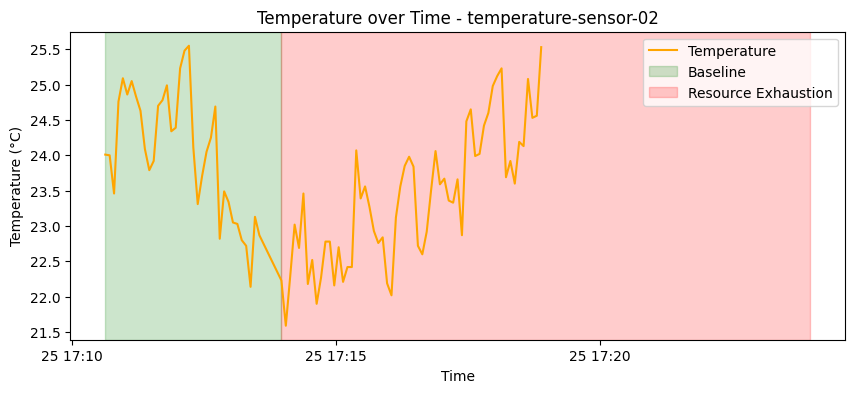

In [14]:
import matplotlib.pyplot as plt

selected_sensor = "temperature-sensor-02"
sensor_df = metrics_df[metrics_df['sensor'] == selected_sensor].copy()
sensor_df = sensor_df.sort_values('datetime')
sensor_events = events_df[events_df['sensor'] == selected_sensor]

baseline_start = sensor_events[sensor_events['event'] == 'baseline']['datetime'].min()
resource_start = sensor_events[sensor_events['event'] == 'resource_exhaustion']['datetime'].min()
baseline_end = resource_start
resource_end = resource_start + pd.Timedelta(minutes=10)

plt.figure(figsize=(10,4))
plt.plot(sensor_df['datetime'], sensor_df['sensor_temperature'], label='Temperature', color='orange')
plt.axvspan(baseline_start, baseline_end, color='green', alpha=0.2, label='Baseline')
plt.axvspan(resource_start, resource_end, color='red', alpha=0.2, label='Resource Exhaustion')
plt.title(f"Temperature over Time - {selected_sensor}")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


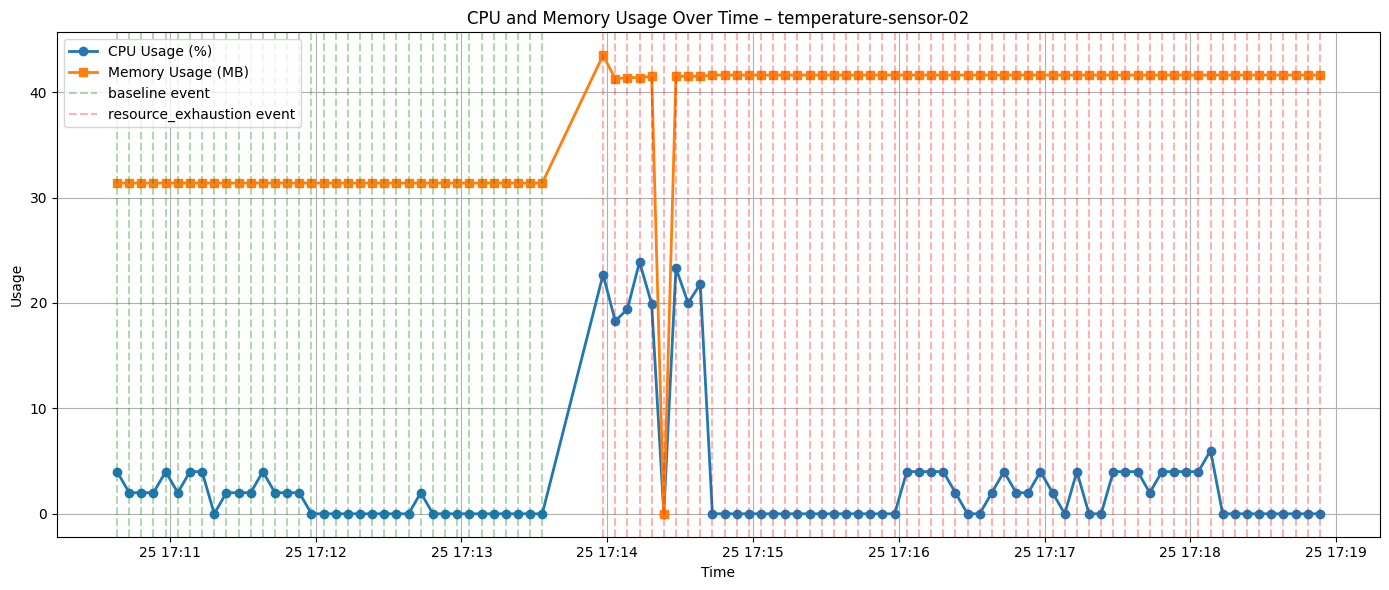

In [17]:
import matplotlib.pyplot as plt

# Sensor to focus on
selected_sensor = 'temperature-sensor-02'

# Filter data
sensor_data = metrics_df[metrics_df['sensor'] == selected_sensor]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(sensor_data['datetime'], sensor_data['sensor_cpu_usage_percent'], label='CPU Usage (%)', marker='o', linewidth=2)
ax.plot(sensor_data['datetime'], sensor_data['sensor_memory_usage_mb'], label='Memory Usage (MB)', marker='s', linewidth=2)

# Add event markers
for event_type, color in [('baseline', 'green'), ('resource_exhaustion', 'red')]:
    event_times = sensor_data[sensor_data['event'] == event_type]['datetime']
    for et in event_times:
        ax.axvline(et, color=color, linestyle='--', alpha=0.3, label=f'{event_type} event')

# De-duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper left')

ax.set_title(f'CPU and Memory Usage Over Time – {selected_sensor}')
ax.set_xlabel('Time')
ax.set_ylabel('Usage')
ax.grid(True)
plt.tight_layout()
plt.show()


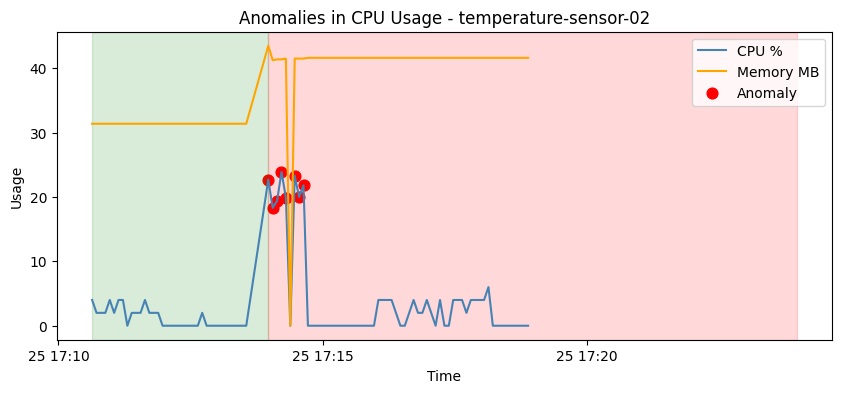

In [16]:
from scipy import stats

z_scores = stats.zscore(sensor_df['sensor_cpu_usage_percent'].fillna(0))
anomaly_mask = abs(z_scores) > 2
anomaly_points = sensor_df[anomaly_mask]

plt.figure(figsize=(10,4))
plt.plot(sensor_df['datetime'], sensor_df['sensor_cpu_usage_percent'], label='CPU %', color='steelblue')
plt.plot(sensor_df['datetime'], sensor_df['sensor_memory_usage_mb'], label='Memory MB', color='orange')
plt.scatter(anomaly_points['datetime'], anomaly_points['sensor_cpu_usage_percent'], color='red', s=60, label='Anomaly')
plt.axvspan(baseline_start, baseline_end, color='green', alpha=0.15)
plt.axvspan(resource_start, resource_end, color='red', alpha=0.15)
plt.title(f"Anomalies in CPU Usage - {selected_sensor}")
plt.xlabel("Time")
plt.ylabel("Usage")
plt.legend()
plt.show()
